In [20]:
!git clone https://github.com/leggedrobotics/rsl_rl.git

fatal: destination path 'rsl_rl' already exists and is not an empty directory.


In [21]:
import os

# Change to the rsl_rl directory
os.chdir('/content/rsl_rl')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/rsl_rl


In [22]:
pip_install_command = '!pip install -e .'

# Execute the pip install command
import subprocess
result = subprocess.run(pip_install_command[1:].split(), capture_output=True, text=True, shell=False)

# Print stdout and stderr for visibility
print(result.stdout)
print(result.stderr)

# Verify tensordict installation
try:
    import tensordict
    print("tensordict installed successfully.")
except ImportError:
    print("tensordict not found. Please ensure it's installed.")

Obtaining file:///content/rsl_rl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for rsl-rl-lib (pyproject.toml): started
  Building editable for rsl-rl-lib (pyproject.toml): finished with status 'done'
  Created wheel for rsl-rl-lib: filename=rsl_rl_lib-3.2.0-0.editable-py3-none-any.whl size=5934 sha256=505d5a8bc76dc3663d940c836237055a415fca02d46a893a3b2deeb907eb0f09
  Stored in directory: /tmp/pip-ephem-wheel-cache-_mp6y07y/wheels/b6/b0/60/a45bf1744a4c125432189eb3b101fee48d5d8255d922796663
Successfully built rsl-rl-lib
  Att

In [23]:
import gymnasium as gym
import torch
from tensordict import TensorDict

# Import RSL-RL components
from rsl_rl.modules import ActorCritic
from rsl_rl.storage import RolloutStorage
from rsl_rl.algorithms import PPO
from rsl_rl.utils import resolve_obs_groups
from rsl_rl.modules import ActorCritic
print("rsl_rl components imported successfully.")

rsl_rl components imported successfully.


# General Steps followed on repository


In [6]:
import yaml

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 1500   # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: null  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""

cfg = yaml.safe_load(yaml_config_string)
print(cfg)


{'runner': {'class_name': 'OnPolicyRunner', 'num_steps_per_env': 24, 'max_iterations': 1500, 'seed': 1, 'obs_groups': {'policy': ['policy'], 'critic': ['policy', 'privileged']}, 'save_interval': 50, 'experiment_name': 'walking_experiment', 'run_name': '', 'logger': 'tensorboard', 'neptune_project': 'legged_gym', 'wandb_project': 'legged_gym', 'policy': {'class_name': 'ActorCritic', 'activation': 'elu', 'actor_obs_normalization': False, 'critic_obs_normalization': False, 'actor_hidden_dims': [256, 256, 256], 'critic_hidden_dims': [256, 256, 256], 'init_noise_std': 1.0, 'noise_std_type': 'scalar', 'state_dependent_std': False}, 'algorithm': {'class_name': 'PPO', 'learning_rate': 0.001, 'num_learning_epochs': 5, 'num_mini_batches': 4, 'schedule': 'adaptive', 'value_loss_coef': 1.0, 'clip_param': 0.2, 'use_clipped_value_loss': True, 'desired_kl': 0.01, 'entropy_coef': 0.01, 'gamma': 0.99, 'lam': 0.95, 'max_grad_norm': 1.0, 'normalize_advantage_per_mini_batch': False, 'rnd_cfg': {'weight': 

In [24]:
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

import os
import time
import torch
import warnings
from tensordict import TensorDict

from rsl_rl.algorithms import PPO
from rsl_rl.env import VecEnv
from rsl_rl.modules import (
    ActorCritic,
    ActorCriticCNN,
    ActorCriticRecurrent,
    resolve_rnd_config,
    resolve_symmetry_config,
    symmetry,
)
from rsl_rl.storage import RolloutStorage
from rsl_rl.utils import resolve_obs_groups
from rsl_rl.utils.logger import Logger


class OnPolicyRunner:
    """On-policy runner for training and evaluation of actor-critic methods."""

    def __init__(self, env: CartPoleVecEnv, train_cfg: dict, log_dir: str | None = None, device: str = "cpu") -> None:
        self.cfg = train_cfg
        self.policy_cfg = train_cfg["policy"]
        self.alg_cfg = train_cfg["algorithm"]
        self.device = device
        self.env = env

        # Setup multi-GPU training if enabled
        self._configure_multi_gpu()

        # Query observations from environment for algorithm construction
        obs = self.env.get_observations()
        self.cfg["obs_groups"] = resolve_obs_groups(obs, self.cfg["obs_groups"], self._get_default_obs_sets())

        # Create the algorithm
        self.alg = self._construct_algorithm(obs)

        # Create the logger
        self.logger = Logger(
            log_dir=log_dir,
            cfg=self.cfg,
            env_cfg=self.env.cfg,
            num_envs=self.env.num_envs,
            is_distributed=self.is_distributed,
            gpu_world_size=self.gpu_world_size,
            gpu_global_rank=self.gpu_global_rank,
            device=self.device,
        )

        self.current_learning_iteration = 0

    def learn(self, num_learning_iterations: int, init_at_random_ep_len: bool = False) -> None:
        # Randomize initial episode lengths (for exploration)
        if init_at_random_ep_len:
            self.env.episode_length_buf = torch.randint_like(
                self.env.episode_length_buf, high=int(self.env.max_episode_length)
            )

        # Start learning
        obs = self.env.get_observations().to(self.device)
        self.train_mode()  # switch to train mode (for dropout for example)

        # Ensure all parameters are in-synced
        if self.is_distributed:
            print(f"Synchronizing parameters for rank {self.gpu_global_rank}...")
            self.alg.broadcast_parameters()

        # Start training
        start_it = self.current_learning_iteration
        total_it = start_it + num_learning_iterations
        for it in range(start_it, total_it):
            start = time.time()
            # Rollout
            with torch.inference_mode():
                for _ in range(self.cfg["num_steps_per_env"]):
                    # Sample actions
                    actions = self.alg.act(obs)
                    # Step the environment
                    obs, rewards, dones, extras = self.env.step(actions.to(self.env.device))
                    # Move to device
                    obs, rewards, dones = (obs.to(self.device), rewards.to(self.device), dones.to(self.device))
                    # Process the step
                    self.alg.process_env_step(obs, rewards, dones, extras)
                    # Extract intrinsic rewards (only for logging)
                    intrinsic_rewards = self.alg.intrinsic_rewards if self.alg_cfg["rnd_cfg"] else None
                    # Book keeping
                    self.logger.process_env_step(rewards, dones, extras, intrinsic_rewards)

                stop = time.time()
                collect_time = stop - start
                start = stop

                # Compute returns
                self.alg.compute_returns(obs)

            # Update policy
            loss_dict = self.alg.update()

            stop = time.time()
            learn_time = stop - start
            self.current_learning_iteration = it

            # Log information
            self.logger.log(
                it=it,
                start_it=start_it,
                total_it=total_it,
                collect_time=collect_time,
                learn_time=learn_time,
                loss_dict=loss_dict,
                learning_rate=self.alg.learning_rate,
                action_std=self.alg.policy.action_std,
                rnd_weight=self.alg.rnd.weight if self.alg_cfg["rnd_cfg"] else None,
            )

            # Save model
            if it % self.cfg["save_interval"] == 0:
                self.save(os.path.join(self.logger.log_dir, f"model_{it}.pt"))  # type: ignore

        # Save the final model after training
        if self.logger.log_dir is not None and not self.logger.disable_logs:
            self.save(os.path.join(self.logger.log_dir, f"model_{self.current_learning_iteration}.pt"))

    def save(self, path: str, infos: dict | None = None) -> None:
        # Save model
        saved_dict = {
            "model_state_dict": self.alg.policy.state_dict(),
            "optimizer_state_dict": self.alg.optimizer.state_dict(),
            "iter": self.current_learning_iteration,
            "infos": infos,
        }
        # Save RND model if used
        if self.alg_cfg["rnd_cfg"]:
            saved_dict["rnd_state_dict"] = self.alg.rnd.state_dict()
            if self.alg.rnd_optimizer:
                saved_dict["rnd_optimizer_state_dict"] = self.alg.rnd_optimizer.state_dict()
        torch.save(saved_dict, path)

        # Upload model to external logging services
        self.logger.save_model(path, self.current_learning_iteration)

    def load(self, path: str, load_optimizer: bool = True, map_location: str | None = None) -> dict:
        loaded_dict = torch.load(path, weights_only=False, map_location=map_location)
        # Load model
        resumed_training = self.alg.policy.load_state_dict(loaded_dict["model_state_dict"])
        # Load RND model if used
        if self.alg_cfg["rnd_cfg"]:
            self.alg.rnd.load_state_dict(loaded_dict["rnd_state_dict"])
        # Load optimizer if used
        if load_optimizer and resumed_training:
            # Algorithm optimizer
            self.alg.optimizer.load_state_dict(loaded_dict["optimizer_state_dict"])
            # RND optimizer if used
            if self.alg_cfg["rnd_cfg"]:
                self.alg.rnd_optimizer.load_state_dict(loaded_dict["rnd_optimizer_state_dict"])
        # Load current learning iteration
        if resumed_training:
            self.current_learning_iteration = loaded_dict["iter"]
        return loaded_dict["infos"]

    def get_inference_policy(self, device: str | None = None) -> callable:
        self.eval_mode()  # Switch to evaluation mode (e.g. for dropout)
        if device is not None:
            self.alg.policy.to(device)
        return self.alg.policy.act_inference

    def train_mode(self) -> None:
        # PPO
        self.alg.policy.train()
        # RND
        if self.alg_cfg["rnd_cfg"]:
            self.alg.rnd.train()

    def eval_mode(self) -> None:
        # PPO
        self.alg.policy.eval()
        # RND
        if self.alg_cfg["rnd_cfg"]:
            self.alg.rnd.eval()

    def add_git_repo_to_log(self, repo_file_path: str) -> None:
        self.logger.git_status_repos.append(repo_file_path)

    def _get_default_obs_sets(self) -> list[str]:
        """Get the the default observation sets required for the algorithm.

        .. note::
            See :func:`resolve_obs_groups` for more details on the handling of observation sets.
        """
        default_sets = ["critic"]
        if "rnd_cfg" in self.alg_cfg and self.alg_cfg["rnd_cfg"] is not None:
            default_sets.append("rnd_state")
        return default_sets

    def _configure_multi_gpu(self) -> None:
        """Configure multi-gpu training."""
        # Check if distributed training is enabled
        self.gpu_world_size = int(os.getenv("WORLD_SIZE", "1"))
        self.is_distributed = self.gpu_world_size > 1

        # If not distributed training, set local and global rank to 0 and return
        if not self.is_distributed:
            self.gpu_local_rank = 0
            self.gpu_global_rank = 0
            self.multi_gpu_cfg = None
            return

        # Get rank and world size
        self.gpu_local_rank = int(os.getenv("LOCAL_RANK", "0"))
        self.gpu_global_rank = int(os.getenv("RANK", "0"))

        # Make a configuration dictionary
        self.multi_gpu_cfg = {
            "global_rank": self.gpu_global_rank,  # Rank of the main process
            "local_rank": self.gpu_local_rank,  # Rank of the current process
            "world_size": self.gpu_world_size,  # Total number of processes
        }

        # Check if user has device specified for local rank
        if self.device != f"cuda:{self.gpu_local_rank}":
            raise ValueError(
                f"Device '{self.device}' does not match expected device for local rank '{self.gpu_local_rank}'."
            )
        # Validate multi-GPU configuration
        if self.gpu_local_rank >= self.gpu_world_size:
            raise ValueError(
                f"Local rank '{self.gpu_local_rank}' is greater than or equal to world size '{self.gpu_world_size}'."
            )
        if self.gpu_global_rank >= self.gpu_world_size:
            raise ValueError(
                f"Global rank '{self.gpu_global_rank}' is greater than or equal to world size '{self.gpu_world_size}'."
            )

        # Initialize torch distributed
        torch.distributed.init_process_group(backend="nccl", rank=self.gpu_global_rank, world_size=self.gpu_world_size)
        # Set device to the local rank
        torch.cuda.set_device(self.gpu_local_rank)

    def _construct_algorithm(self, obs: TensorDict) -> PPO:
        """Construct the actor-critic algorithm."""
        # Resolve RND config if used
        self.alg_cfg = resolve_rnd_config(self.alg_cfg, obs, self.cfg["obs_groups"], self.env)

        # Resolve symmetry config if used
        self.alg_cfg = resolve_symmetry_config(self.alg_cfg, self.env)

        # Resolve deprecated normalization config
        if self.cfg.get("empirical_normalization") is not None:
            warnings.warn(
                "The `empirical_normalization` parameter is deprecated. Please set `actor_obs_normalization` and "
                "`critic_obs_normalization` as part of the `policy` configuration instead.",
                DeprecationWarning,
            )
            if self.policy_cfg.get("actor_obs_normalization") is None:
                self.policy_cfg["actor_obs_normalization"] = self.cfg["empirical_normalization"]
            if self.policy_cfg.get("critic_obs_normalization") is None:
                self.policy_cfg["critic_obs_normalization"] = self.cfg["empirical_normalization"]

        # Initialize the policy
        actor_critic_class = eval(self.policy_cfg.pop("class_name"))
        actor_critic: ActorCritic | ActorCriticRecurrent | ActorCriticCNN = actor_critic_class(
            obs, self.cfg["obs_groups"], self.env.num_actions, **self.policy_cfg
        ).to(self.device)

        # Initialize the storage
        storage = RolloutStorage(
            "rl", self.env.num_envs, self.cfg["num_steps_per_env"], obs, [self.env.num_actions], self.device
        )

        # Initialize the algorithm
        alg_class = eval(self.alg_cfg.pop("class_name"))
        alg: PPO = alg_class(
            actor_critic, storage, device=self.device, **self.alg_cfg, multi_gpu_cfg=self.multi_gpu_cfg
        )

        return alg

In [25]:
import gymnasium as gym
import torch
from gymnasium import spaces
from tensordict import TensorDict
from rsl_rl.env import VecEnv


class CartPoleVecEnv(VecEnv):
    def __init__(self, num_envs: int = 8, device: str = "cpu", max_episode_length: int = 500):
        self.num_envs = num_envs
        self.device = torch.device(device)
        self.max_episode_length = max_episode_length
        self.episode_length_buf = torch.zeros(num_envs, dtype=torch.long, device=self.device)

        # underlying envs
        self.envs = [gym.make("CartPole-v1") for _ in range(num_envs)]
        base_env = self.envs[0]

        # expose gym-like spaces so rsl_rl infers dims cleanly
        self.observation_space = base_env.observation_space  # Box(4,)
        self.action_space = base_env.action_space            # Discrete(2)

        self.num_actions = int(self.action_space.n)

        obs0, _ = base_env.reset()
        obs_dim = obs0.shape[0]
        self.obs_buf = torch.zeros(num_envs, obs_dim, device=self.device, dtype=torch.float32)

        self.cfg = {"env_name": "CartPole-v1"}

        class _DummyUnwrapped:
            def __init__(self, step_dt: float):
                self.step_dt = step_dt

        # CartPole dt
        self.unwrapped = _DummyUnwrapped(step_dt=0.02)

        self._reset_all()

    def _reset_all(self):
        for i, env in enumerate(self.envs):
            o, _ = env.reset()
            self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
        self.episode_length_buf.zero_()

    def get_observations(self) -> TensorDict:
        return TensorDict(
            {
                "policy": self.obs_buf.clone(),
                "privileged": self.obs_buf.clone(),
            },
            batch_size=[self.num_envs],
            device=self.device,
        )

    def step(self, actions: torch.Tensor):
        # Handle different action shapes from the policy:
        # (num_envs, num_actions) → choose greedy action
        if actions.dim() == 2 and actions.shape[1] > 1:
            actions = torch.argmax(actions, dim=-1)

        # (num_envs, 1) → squeeze to (num_envs,)
        if actions.dim() == 2:
            actions = actions.squeeze(-1)

        rewards = torch.zeros(self.num_envs, device=self.device)
        dones = torch.zeros(self.num_envs, dtype=torch.bool, device=self.device)
        time_outs = torch.zeros(self.num_envs, dtype=torch.bool, device=self.device)

        for i, env in enumerate(self.envs):
            a = int(actions[i].item())
            o, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
            rewards[i] = r
            dones[i] = done

            self.episode_length_buf[i] += 1
            if self.episode_length_buf[i] >= self.max_episode_length:
                time_outs[i] = True
                done = True

            if done:
                o, _ = env.reset()
                self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
                self.episode_length_buf[i] = 0

        obs_td = self.get_observations()
        extras = {
            "time_outs": time_outs,
            "log": {},
        }
        return obs_td, rewards, dones, extras


In [26]:
from rsl_rl.modules import symmetry
print(symmetry)

<module 'rsl_rl.modules.symmetry' from '/content/rsl_rl/rsl_rl/modules/symmetry.py'>


In [18]:
%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

from rsl_rl.env import VecEnv


import torch
from tensordict import TensorDict
from typing import TYPE_CHECKING

# cartpole_symmetry.py
import torch

@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    """Augments the given observations and actions by applying symmetry transformations.

    This function creates augmented versions of the provided observations and actions by applying
    two symmetrical transformations: original, left-right. The symmetry
    transformations are beneficial for reinforcement learning tasks by providing additional
    diverse data without requiring additional data collection.

    Args:
        env: The environment instance.
        obs: The original observation tensor dictionary. Defaults to None.
        actions: The original actions tensor. Defaults to None.

    Returns:
        Augmented observations and actions tensors, or None if the respective input was None.
    """

    # observations
    if obs is not None:
        batch_size = obs.batch_size[0]
        # since we have 2 different symmetries, we need to augment the batch size by 2
        obs_aug = obs.repeat(2)
        # -- original
        obs_aug["policy"][:batch_size] = obs["policy"][:]
        # -- left-right
        obs_aug["policy"][batch_size : 2 * batch_size] = -obs["policy"]
    else:
        obs_aug = None

    # actions
    if actions is not None:
        batch_size = actions.shape[0]
        # since we have 4 different symmetries, we need to augment the batch size by 4
        actions_aug = torch.zeros(batch_size * 2, actions.shape[1], device=actions.device)
        # -- original
        actions_aug[:batch_size] = actions[:]
        # -- left-right
        actions_aug[batch_size : 2 * batch_size] = 1 - actions


    return obs_aug, actions_aug

Overwriting /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


#Flipping code


In [25]:
%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

from rsl_rl.env import VecEnv


# cartpole_symmetry.py
import torch

@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    # obs: TensorDict or None
    # actions: tensor or None
    # env: your CartPoleVecEnv

    obs_sym = obs
    act_sym = actions

    if obs is not None:
        s = obs["policy"]              # (B, 4)
        s_sym = -s                     # simple mirror
        obs_sym = obs.clone()
        obs_sym["policy"] = s_sym
        if "privileged" in obs_sym.keys():
            obs_sym["privileged"] = s_sym

    if actions is not None:
        act_sym = 1 - actions          # assumes discrete {0,1}

    return obs_sym, act_sym


def resolve_symmetry_config(alg_cfg: dict, env: VecEnv) -> dict:
    """Resolve the symmetry configuration.

    Args:
        alg_cfg: Algorithm configuration dictionary.
        env: Environment object.

    Returns:
        The resolved algorithm configuration dictionary.
    """
    # If using symmetry then pass the environment config object
    # Note: This is used by the symmetry function for handling different observation terms
    if "symmetry_cfg" in alg_cfg and alg_cfg["symmetry_cfg"] is not None:
        alg_cfg["symmetry_cfg"]["_env"] = env
    else:
        alg_cfg["symmetry_cfg"] = None
    return alg_cfg


Writing /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


In [28]:
'''import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 1500    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 4.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])
'''


OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                           Learning iteration 0/1500                             

                            Total steps: 192 
                       Steps per second: 253 
                        Collection time: 0.429s 
                          Learning time: 0.327s 
                        Mean value loss: 59.3835
                    Mean surrogate loss: 0.1684
                      Mean entropy loss: 2.8420
                          Mean rnd loss: 1.4766
                     Mean symmetry loss: nan
                  Mean extrinsic reward: 18.67
                  Mean intrinsic reward: 0.00
                            Mean reward: 18.67
                    Mean episode length: 18.67
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 0.76s
                           Time elapsed: 00:00:

KeyboardInterrupt: 

# manual flip output


In [19]:
import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 100    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])


OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                            Learning iteration 0/100                             

                            Total steps: 192 
                       Steps per second: 169 
                        Collection time: 0.502s 
                          Learning time: 0.629s 
                        Mean value loss: 50.1557
                    Mean surrogate loss: 0.2445
                      Mean entropy loss: 2.8346
                          Mean rnd loss: 0.0689
                     Mean symmetry loss: 0.1200
                  Mean extrinsic reward: 15.67
                  Mean intrinsic reward: 0.00
                            Mean reward: 15.67
                    Mean episode length: 15.67
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 1.13s
                           Time elapsed: 00:

# Symmetry Generators

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

import math
from collections import deque

In [36]:
import torch.nn as nn
import numpy as np

def frobenius_normalize(A):
    return A / A.norm(p='fro')

def exp_approx(x, order=10):
    """Tensor exponential using Taylor series approximation"""
    result = 0
    term = torch.eye(n=x.shape[0], device=x.device)
    result = result + term
    for i in range(1, order+1):
        term = torch.mm(term, x)/i
        result = result + term
    return result

class GeneratorLatent(nn.Module):
    """Single symmetry generator"""

    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.algebra = nn.Parameter(torch.empty((num_features, num_features)))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.algebra, a=math.sqrt(5))

class GroupLatent(nn.Module):
    def __init__(self,num_features, num_generators, LOSS_MODE = "MAE"): ## MAE works better than MSE but takes longer to converge and gives sparser generators
        super().__init__()
        self.num_generators = num_generators
        self.LOSS_MODE = LOSS_MODE
        self.num_features = num_features
        self.group = nn.ModuleList([GeneratorLatent(self.num_features) for i in range(self.num_generators)])
        self.reset_parameters()
        self.criterion_cos = nn.CosineSimilarity(dim=0)
        self.eps = 1e-5


    def reset_parameters(self) -> None:
        for generator in self.group:
            generator.reset_parameters()

    def forward(self, theta, x, order=10):
        """Apply group transformations"""
        transformed = x.clone()
        for i, generator in enumerate(self.group):
            inter = 0
            term = torch.eye(x.shape[-1], device=x.device)
            inter = inter + term.expand(x.shape[0], -1, -1)
            for k in range(1, order+1, 1):
                THETA = ((theta[i])**k)[:, None, None].expand(x.shape[0], x.shape[-1], x.shape[-1])
                term = (term@generator.algebra)/k
                inter = inter + THETA*term.expand(x.shape[0], -1, -1)

            transformed = torch.bmm(inter, transformed[:, :, None]).squeeze()
        return transformed

    def orthogonal_loss_kon(self):
        """Orthogonality loss between generators"""
        loss = 0
        for i, generator1 in enumerate(self.group):
            for j, generator2 in enumerate(self.group):
                if i < j:
                    mat1_norm = frobenius_normalize(generator1.algebra)
                    mat2_norm = frobenius_normalize(generator2.algebra)
                    loss = loss + torch.sum((mat1_norm * mat2_norm)**2)
        return loss

def generate_latent_data_from_trained_agent(trained_agent, env_name='CartPole-v1',
                                           num_samples=100000, device='cpu'):
    """
    Generate latent representations from trained PPO agent
    This is the bridge between RL and symmetry detection
    """
    print("=== Generating Latent Data from Trained Agent ===")

    env = gym.make(env_name)
    latent_data = []

    with torch.no_grad():
        for _ in tqdm(range(num_samples), desc="Collecting latent data"):
            # Reset environment periodically
            if len(latent_data) % 1000 == 0:
                state, _ = env.reset()

            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Get latent representation from trained agent
            latent = trained_agent.get_latent(state_tensor)
            latent_data.append(latent.squeeze().cpu())

            # Take action to get new state
            action, _, _, _ = trained_agent.get_action(state_tensor)
            state, _, done, _, _ = env.step(action)

            if done:
                state, _ = env.reset()

    env.close()

    # Convert to tensor
    latent_tensor = torch.stack(latent_data)
    print(f"Generated {latent_tensor.shape[0]} latent samples of dimension {latent_tensor.shape[1]}")

    return latent_tensor

def psi_4d(x):
    """Invariant function for 4D latent space"""
    M = torch.eye(4, device=x.device)
    return torch.sum((x @ M) * x, dim=1)


def train_symmetry_generators(model_symmetry, latent_data, device='cpu',
                              epochs=50, batch_size=1024, M=None):
    """
    PHASE 2: Train symmetry generators on fixed latent data
    No RL training here - pure symmetry learning
    """
    print("=== PHASE 2: Training Symmetry Generators ===")

    optimizer = torch.optim.Adam(model_symmetry.parameters(), lr=1e-2)
    criterion_mse = nn.MSELoss()
    orth_coeff = 0.5
    skew_sym_coeff = 0.1 # Coefficient for skew-symmetry regularization
    magnitude_coeff = 0.01 # Coefficient for magnitude regularization

    # Convert latent_data to a PyTorch tensor if it's a NumPy array
    if isinstance(latent_data, np.ndarray):
        latent_data = torch.from_numpy(latent_data).float().to(device)
    else:
        latent_data = latent_data.to(device)

    # Use the attribute present in the provided object
    num_generators = getattr(model_symmetry, "num_generators", None)
    if num_generators is None:
        num_generators = getattr(model_symmetry, "numgenerators")  # fallback to notebook's attribute name

    loss_closure_history = []
    loss_orth_history = []
    loss_skew_sym_history = []
    loss_magnitude_history = []

    for epoch in range(epochs):
        loss_closure_total = 0
        loss_orth_total = 0
        loss_skew_sym_total = 0
        loss_magnitude_total = 0

        # Shuffle data
        indices = torch.randperm(latent_data.shape[0])
        num_batches = (latent_data.shape[0] // batch_size) + 1

        for i in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}"):
            batch_indices = indices[i*batch_size:(i+1)*batch_size]
            if len(batch_indices) == 0:
                continue

            z = latent_data[batch_indices]

            optimizer.zero_grad()

            # Sample random transformation parameters
            theta = [(2*torch.rand(z.shape[0], device=device) - 1) for _ in range(num_generators)]

            # Apply symmetry transformations
            z_prime = model_symmetry(theta=theta, x=z)

            # Compute losses
            closure_loss = criterion_mse(psi_4d(z), psi_4d(z_prime))
            orthogonal_loss = model_symmetry.orthogonal_loss_kon()

            # Add skew-symmetry and magnitude regularization
            skew_symmetry_loss = 0
            magnitude_loss = 0
            for generator in model_symmetry.group:
                G = generator.algebra
                skew_symmetry_loss += torch.sum((G + G.T)**2) # Penalize non-skew-symmetry
                magnitude_loss += torch.norm(G, p='fro')**2 # Penalize small generators

            # Total loss
            loss_S = closure_loss + orth_coeff * orthogonal_loss + \
                     skew_sym_coeff * skew_symmetry_loss + magnitude_coeff * magnitude_loss
            loss_S.backward()

            optimizer.step()

            loss_closure_total += closure_loss.item()
            loss_orth_total += orthogonal_loss.item()
            loss_skew_sym_total += skew_symmetry_loss.item()
            loss_magnitude_total += magnitude_loss.item()

        # Average losses
        avg_closure = loss_closure_total / num_batches
        avg_orth = loss_orth_total / num_batches
        avg_skew_sym = loss_skew_sym_total / num_batches
        avg_magnitude = loss_magnitude_total / num_batches

        loss_closure_history.append(avg_closure)
        loss_orth_history.append(avg_orth)
        loss_skew_sym_history.append(avg_skew_sym)
        loss_magnitude_history.append(avg_magnitude)

        print(f"Epoch {epoch+1} - Closure: {avg_closure:.6f}, Orthogonality: {avg_orth:.6f}, Skew-Sym: {avg_skew_sym:.6f}, Magnitude: {avg_magnitude:.6f}")

        # Memory cleanup
        if device.startswith('cuda'):
            torch.cuda.empty_cache()

    # ===== Example usage after training (uses Taylor-series expapprox) =====
    # expapprox(x, order=10) must be defined in the notebook as the Taylor-series matrix exponential
    # z′ = (Π_i exp(θ_i G_i)) z, computed per-sample
    print("\n=== EXAMPLE USAGE AFTER TRAINING ===")
    with torch.no_grad():
        # Small evaluation batch
        B = min(4, latent_data.shape[0])
        z_eval = latent_data[:B]  # (B, D)
        D = z_eval.shape[1]

        # Sample θ per generator per sample (same distribution as training)
        theta_eval = [2*torch.rand(B, device=device) - 1 for _ in range(num_generators)]

        # Build per-sample product Π_i exp(θ_i G_i) using expapprox
        product = torch.eye(D, device=device).unsqueeze(0).repeat(B, 1, 1)  # (B, D, D)
        for i, gen in enumerate(model_symmetry.group):
            G = gen.algebra.detach().to(device)  # (D, D)
            Mi_batch = torch.stack([exp_approx(theta_eval[i][j] * G, order=10) for j in range(B)], dim=0)  # (B, D, D)
            product = torch.bmm(Mi_batch, product)  # left-multiply to match forward order

        # Apply the product to z to get z′
        z_prime_eval_from_product = torch.bmm(product, z_eval.unsqueeze(-1)).squeeze(-1)  # (B, D)

        # Also compute z′ via the model's forward to cross-check
        z_prime_eval_model = model_symmetry(theta=theta_eval, x=z_eval)

        # Print results
        print("Original z (eval batch):")
        print(z_eval)
        print("\nPer-sample product Π exp(θ_i G_i) with Taylor approximation (B, D, D):")
        print(product)
        print("\nz′ from product = (Π exp(θ_i G_i)) @ z:")
        print(z_prime_eval_from_product)
        print("\nz′ from model forward (for cross-check):")
        print(z_prime_eval_model)

        # Optional: quick consistency check (mean absolute diff)
        mad = (z_prime_eval_from_product - z_prime_eval_model).abs().mean().item()
        print(f"\nMean |z′(product) - z′(model)| = {mad:.6e}")

    return loss_closure_history, loss_orth_history

def plot_generators(model_symmetry, title="SO(4) CartPole Symmetry Generators"):
    """Visualize learned generators"""
    generators = [g.algebra.detach().cpu().numpy() for g in model_symmetry.group]
    G = len(generators)

    n_cols = 9
    n_rows = (G + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3.5 * n_rows))
    axes = axes.flatten()

    for i in range(G):
        vmax = np.max(np.abs(generators[i]))
        im = axes[i].imshow(generators[i], cmap='bwr', interpolation='nearest',
                           vmin=-vmax, vmax=vmax)
        axes[i].set_title(f'Generator {i}', fontsize=10)
        axes[i].axis('off')
        fig.colorbar(im, ax=axes[i], shrink=0.7)

    for j in range(G, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def analyze_generators(model_symmetry):
    """Analyze learned generators"""
    print("=== Generator Analysis ===")

    generators = [g.algebra.detach().cpu().numpy() for g in model_symmetry.group]

    for i, gen in enumerate(generators):
        print(f"\nGenerator {i}:")
        print(f"  Shape: {gen.shape}")
        print(f"  Min: {gen.min():.4f}, Max: {gen.max():.4f}")
        print(f"  Mean: {gen.mean():.6f}, Std: {gen.std():.4f}")
        print(f"  Frobenius norm: {np.linalg.norm(gen, 'fro'):.4f}")

        # Check if skew-symmetric (Lie algebra property)
        skew_symmetric = np.allclose(gen, -gen.T, atol=1e-3)
        print(f"  Skew-symmetric: {skew_symmetric}")


In [32]:
device="cuda:0"
M = torch.eye(4, device="cuda:0")

In [ ]:
#%pip uninstall -y gym
#%pip install "gymnasium[mujoco]" "stable_baselines3[extra]" "numpy<2.0"

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-python
  

In [ ]:
!pip install tqdm

In [64]:
import gymnasium as gym
import torch
import numpy as np
from tqdm import tqdm

def generate_improved_cartpole_dataset(num_episodes=5000, max_steps=300, device='cpu'):
    """
    Generate larger, more diverse symmetry-aware CartPole dataset.
    Returns ONLY the final normalized dataset tensor.
    """
    print("Generating Improved Symmetry-Aware CartPole Dataset...")

    # Reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    env = gym.make('CartPole-v1', render_mode=None)
    all_states = []

    for _ in tqdm(range(num_episodes), desc="Episodes"):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        episode_states = []

        for _ in range(max_steps):
            # --- Diverse actions: mix of policy and random ---
            # If angle (index 2) is significant (> 0.1 rad), use policy to stabilize
            if np.abs(state[2]) > 0.1:
                action = 1 if state[2] > 0 else 0
            else:
                # Otherwise random exploration
                action = env.action_space.sample()

            step_result = env.step(action)
            next_state = step_result[0]
            terminated = step_result[2]
            truncated = step_result[3] if len(step_result) > 4 else False

            episode_states.append(state.copy())
            state = next_state

            if terminated or truncated:
                break

        all_states.extend(episode_states)

    env.close()

    # --- Create symmetric dataset (original + reflected) ---
    states = np.array(all_states)
    reflected = states.copy()
    reflected[:, [0, 1]] *= -1  # Reflect position and velocity

    full_dataset = np.concatenate([states, reflected], axis=0)



    # Save full details to disk (so you don't lose mean/std for un-normalization later)
    torch.save({
        'raw_data': full_dataset
    }, 'improved_cartpole_symmetry.pt')

    print(f"Saved dataset to disk. Total samples: {len(full_dataset)}")

    # Return ONLY the final dataset as requested
    return full_dataset



In [65]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

latent_data = generate_improved_cartpole_dataset(device=device)

Generating Improved Symmetry-Aware CartPole Dataset...


Episodes: 100%|██████████| 5000/5000 [00:04<00:00, 1201.48it/s]


Saved dataset to disk. Total samples: 426704


Using device: cuda
Starting complete workflow...
=== PHASE 2: Training Symmetry Generators ===


Epoch 1/50: 100%|██████████| 417/417 [00:12<00:00, 33.24it/s]


Epoch 1 - Closure: 2.727080, Orthogonality: 0.818082, Skew-Sym: 2.782773, Magnitude: 5.231217


Epoch 2/50: 100%|██████████| 417/417 [00:11<00:00, 35.90it/s]


Epoch 2 - Closure: 0.020644, Orthogonality: 0.314845, Skew-Sym: 0.285639, Magnitude: 4.514511


Epoch 3/50: 100%|██████████| 417/417 [00:11<00:00, 35.70it/s]


Epoch 3 - Closure: 0.002503, Orthogonality: 0.032862, Skew-Sym: 0.051148, Magnitude: 3.649291


Epoch 4/50: 100%|██████████| 417/417 [00:11<00:00, 35.06it/s]


Epoch 4 - Closure: 0.000450, Orthogonality: 0.008253, Skew-Sym: 0.010290, Magnitude: 2.544594


Epoch 5/50: 100%|██████████| 417/417 [00:11<00:00, 35.36it/s]


Epoch 5 - Closure: 0.000086, Orthogonality: 0.001732, Skew-Sym: 0.001874, Magnitude: 1.657955


Epoch 6/50: 100%|██████████| 417/417 [00:11<00:00, 35.31it/s]


Epoch 6 - Closure: 0.000018, Orthogonality: 0.000070, Skew-Sym: 0.000432, Magnitude: 1.016771


Epoch 7/50: 100%|██████████| 417/417 [00:11<00:00, 35.70it/s]


Epoch 7 - Closure: 0.000008, Orthogonality: 0.000077, Skew-Sym: 0.000310, Magnitude: 0.633195


Epoch 8/50: 100%|██████████| 417/417 [00:11<00:00, 35.45it/s]


Epoch 8 - Closure: 0.000007, Orthogonality: 0.000187, Skew-Sym: 0.000455, Magnitude: 0.411793


Epoch 9/50: 100%|██████████| 417/417 [00:12<00:00, 32.94it/s]


Epoch 9 - Closure: 0.000007, Orthogonality: 0.000501, Skew-Sym: 0.000854, Magnitude: 0.340232


Epoch 10/50: 100%|██████████| 417/417 [00:11<00:00, 35.51it/s]


Epoch 10 - Closure: 0.000003, Orthogonality: 0.000287, Skew-Sym: 0.000442, Magnitude: 0.193797


Epoch 11/50: 100%|██████████| 417/417 [00:11<00:00, 35.12it/s]


Epoch 11 - Closure: 0.000033, Orthogonality: 0.000765, Skew-Sym: 0.002552, Magnitude: 0.159068


Epoch 12/50: 100%|██████████| 417/417 [00:11<00:00, 35.35it/s]


Epoch 12 - Closure: 0.000068, Orthogonality: 0.001204, Skew-Sym: 0.008279, Magnitude: 0.161893


Epoch 13/50: 100%|██████████| 417/417 [00:11<00:00, 35.34it/s]


Epoch 13 - Closure: 0.000005, Orthogonality: 0.000471, Skew-Sym: 0.000471, Magnitude: 0.085119


Epoch 14/50: 100%|██████████| 417/417 [00:11<00:00, 35.24it/s]


Epoch 14 - Closure: 0.000094, Orthogonality: 0.001291, Skew-Sym: 0.004677, Magnitude: 0.142703


Epoch 15/50: 100%|██████████| 417/417 [00:11<00:00, 35.55it/s]


Epoch 15 - Closure: 0.000014, Orthogonality: 0.000469, Skew-Sym: 0.000786, Magnitude: 0.079343


Epoch 16/50: 100%|██████████| 417/417 [00:11<00:00, 35.59it/s]


Epoch 16 - Closure: 0.000025, Orthogonality: 0.000787, Skew-Sym: 0.001168, Magnitude: 0.073224


Epoch 17/50: 100%|██████████| 417/417 [00:11<00:00, 35.42it/s]


Epoch 17 - Closure: 0.000046, Orthogonality: 0.001512, Skew-Sym: 0.003298, Magnitude: 0.153427


Epoch 18/50: 100%|██████████| 417/417 [00:11<00:00, 35.28it/s]


Epoch 18 - Closure: 0.000017, Orthogonality: 0.001300, Skew-Sym: 0.001471, Magnitude: 0.072069


Epoch 19/50: 100%|██████████| 417/417 [00:11<00:00, 34.88it/s]


Epoch 19 - Closure: 0.000123, Orthogonality: 0.001359, Skew-Sym: 0.006756, Magnitude: 0.175720


Epoch 20/50: 100%|██████████| 417/417 [00:11<00:00, 35.34it/s]


Epoch 20 - Closure: 0.000028, Orthogonality: 0.001260, Skew-Sym: 0.002036, Magnitude: 0.070480


Epoch 21/50: 100%|██████████| 417/417 [00:11<00:00, 35.41it/s]


Epoch 21 - Closure: 0.000116, Orthogonality: 0.001622, Skew-Sym: 0.006715, Magnitude: 0.124380


Epoch 22/50: 100%|██████████| 417/417 [00:11<00:00, 35.14it/s]


Epoch 22 - Closure: 0.000037, Orthogonality: 0.000962, Skew-Sym: 0.000796, Magnitude: 0.144422


Epoch 23/50: 100%|██████████| 417/417 [00:11<00:00, 35.28it/s]


Epoch 23 - Closure: 0.000012, Orthogonality: 0.001127, Skew-Sym: 0.001244, Magnitude: 0.095665


Epoch 24/50: 100%|██████████| 417/417 [00:11<00:00, 35.20it/s]


Epoch 24 - Closure: 0.000177, Orthogonality: 0.002416, Skew-Sym: 0.014109, Magnitude: 0.208702


Epoch 25/50: 100%|██████████| 417/417 [00:11<00:00, 35.44it/s]


Epoch 25 - Closure: 0.000075, Orthogonality: 0.001513, Skew-Sym: 0.002788, Magnitude: 0.151361


Epoch 26/50: 100%|██████████| 417/417 [00:11<00:00, 35.32it/s]


Epoch 26 - Closure: 0.000103, Orthogonality: 0.001640, Skew-Sym: 0.003177, Magnitude: 0.193855


Epoch 27/50: 100%|██████████| 417/417 [00:11<00:00, 35.14it/s]


Epoch 27 - Closure: 0.000028, Orthogonality: 0.001239, Skew-Sym: 0.001010, Magnitude: 0.101319


Epoch 28/50: 100%|██████████| 417/417 [00:11<00:00, 35.28it/s]


Epoch 28 - Closure: 0.000103, Orthogonality: 0.001334, Skew-Sym: 0.002670, Magnitude: 0.189933


Epoch 29/50: 100%|██████████| 417/417 [00:11<00:00, 35.30it/s]


Epoch 29 - Closure: 0.000089, Orthogonality: 0.001511, Skew-Sym: 0.004683, Magnitude: 0.161383


Epoch 30/50: 100%|██████████| 417/417 [00:11<00:00, 35.32it/s]


Epoch 30 - Closure: 0.000037, Orthogonality: 0.001406, Skew-Sym: 0.002340, Magnitude: 0.139574


Epoch 31/50: 100%|██████████| 417/417 [00:11<00:00, 35.29it/s]


Epoch 31 - Closure: 0.000059, Orthogonality: 0.001415, Skew-Sym: 0.001925, Magnitude: 0.128954


Epoch 32/50: 100%|██████████| 417/417 [00:11<00:00, 35.82it/s]


Epoch 32 - Closure: 0.000183, Orthogonality: 0.001603, Skew-Sym: 0.001957, Magnitude: 0.182596


Epoch 33/50: 100%|██████████| 417/417 [00:11<00:00, 35.30it/s]


Epoch 33 - Closure: 0.000038, Orthogonality: 0.001515, Skew-Sym: 0.002558, Magnitude: 0.177982


Epoch 34/50: 100%|██████████| 417/417 [00:11<00:00, 35.82it/s]


Epoch 34 - Closure: 0.000035, Orthogonality: 0.001374, Skew-Sym: 0.002990, Magnitude: 0.164853


Epoch 35/50: 100%|██████████| 417/417 [00:11<00:00, 36.05it/s]


Epoch 35 - Closure: 0.000306, Orthogonality: 0.002100, Skew-Sym: 0.006974, Magnitude: 0.185376


Epoch 36/50: 100%|██████████| 417/417 [00:11<00:00, 35.49it/s]


Epoch 36 - Closure: 0.000071, Orthogonality: 0.001483, Skew-Sym: 0.001414, Magnitude: 0.169172


Epoch 37/50: 100%|██████████| 417/417 [00:11<00:00, 35.46it/s]


Epoch 37 - Closure: 0.000063, Orthogonality: 0.001378, Skew-Sym: 0.001796, Magnitude: 0.173309


Epoch 38/50: 100%|██████████| 417/417 [00:11<00:00, 35.58it/s]


Epoch 38 - Closure: 0.000178, Orthogonality: 0.001547, Skew-Sym: 0.004309, Magnitude: 0.184114


Epoch 39/50: 100%|██████████| 417/417 [00:11<00:00, 35.14it/s]


Epoch 39 - Closure: 0.000046, Orthogonality: 0.001307, Skew-Sym: 0.002246, Magnitude: 0.121887


Epoch 40/50: 100%|██████████| 417/417 [00:11<00:00, 35.41it/s]


Epoch 40 - Closure: 0.000140, Orthogonality: 0.001792, Skew-Sym: 0.003109, Magnitude: 0.199530


Epoch 41/50: 100%|██████████| 417/417 [00:11<00:00, 35.41it/s]


Epoch 41 - Closure: 0.000561, Orthogonality: 0.002130, Skew-Sym: 0.003935, Magnitude: 0.206813


Epoch 42/50: 100%|██████████| 417/417 [00:11<00:00, 35.23it/s]


Epoch 42 - Closure: 0.000064, Orthogonality: 0.001326, Skew-Sym: 0.003756, Magnitude: 0.187784


Epoch 43/50: 100%|██████████| 417/417 [00:11<00:00, 35.54it/s]


Epoch 43 - Closure: 0.000035, Orthogonality: 0.001206, Skew-Sym: 0.001140, Magnitude: 0.108768


Epoch 44/50: 100%|██████████| 417/417 [00:11<00:00, 35.38it/s]


Epoch 44 - Closure: 0.000076, Orthogonality: 0.001305, Skew-Sym: 0.001886, Magnitude: 0.134201


Epoch 45/50: 100%|██████████| 417/417 [00:11<00:00, 34.98it/s]


Epoch 45 - Closure: 0.000030, Orthogonality: 0.001599, Skew-Sym: 0.003092, Magnitude: 0.161488


Epoch 46/50: 100%|██████████| 417/417 [00:11<00:00, 35.05it/s]


Epoch 46 - Closure: 0.000198, Orthogonality: 0.001813, Skew-Sym: 0.006549, Magnitude: 0.159416


Epoch 47/50: 100%|██████████| 417/417 [00:11<00:00, 34.94it/s]


Epoch 47 - Closure: 0.000315, Orthogonality: 0.002555, Skew-Sym: 0.008896, Magnitude: 0.251332


Epoch 48/50: 100%|██████████| 417/417 [00:11<00:00, 35.45it/s]


Epoch 48 - Closure: 0.000027, Orthogonality: 0.000981, Skew-Sym: 0.001346, Magnitude: 0.123121


Epoch 49/50: 100%|██████████| 417/417 [00:11<00:00, 35.38it/s]


Epoch 49 - Closure: 0.000106, Orthogonality: 0.001489, Skew-Sym: 0.004840, Magnitude: 0.127619


Epoch 50/50: 100%|██████████| 417/417 [00:11<00:00, 35.12it/s]


Epoch 50 - Closure: 0.000029, Orthogonality: 0.001538, Skew-Sym: 0.002602, Magnitude: 0.152005

=== EXAMPLE USAGE AFTER TRAINING ===
Original z (eval batch):
tensor([[-0.0224, -0.0307,  0.0248, -0.0026],
        [-0.0230,  0.1641,  0.0248, -0.2873],
        [-0.0197,  0.3589,  0.0190, -0.5721],
        [-0.0126,  0.5537,  0.0076, -0.8587]], device='cuda:0')

Per-sample product Π exp(θ_i G_i) with Taylor approximation (B, D, D):
tensor([[[ 0.9977,  0.0270, -0.0465, -0.0387],
         [-0.0251,  0.9993,  0.0304,  0.0095],
         [ 0.0477, -0.0287,  0.9962, -0.0678],
         [ 0.0432, -0.0104,  0.0663,  0.9970]],

        [[ 0.9850,  0.1649, -0.0400,  0.0327],
         [-0.1654,  0.9852, -0.0389, -0.0261],
         [ 0.0366,  0.0447,  0.9978, -0.0335],
         [-0.0355,  0.0218,  0.0342,  0.9987]],

        [[ 0.9899, -0.1195,  0.0653, -0.0363],
         [ 0.1228,  0.9907, -0.0221,  0.0471],
         [-0.0658,  0.0346,  0.9928, -0.0937],
         [ 0.0250, -0.0482,  0.0981,  0.9936]],

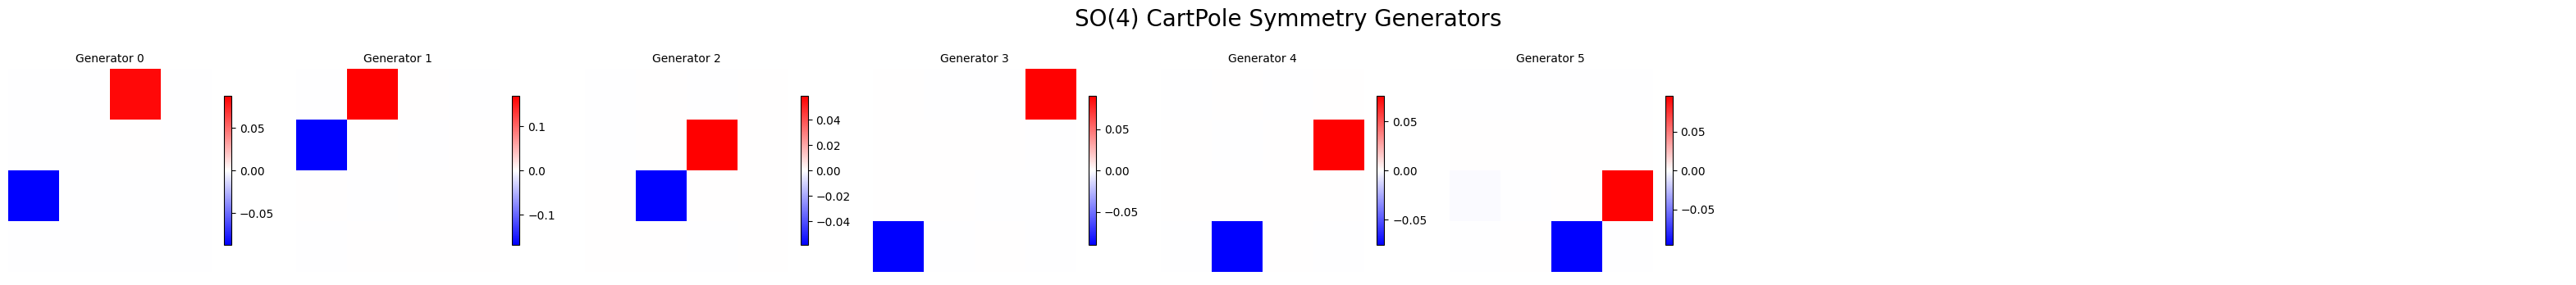

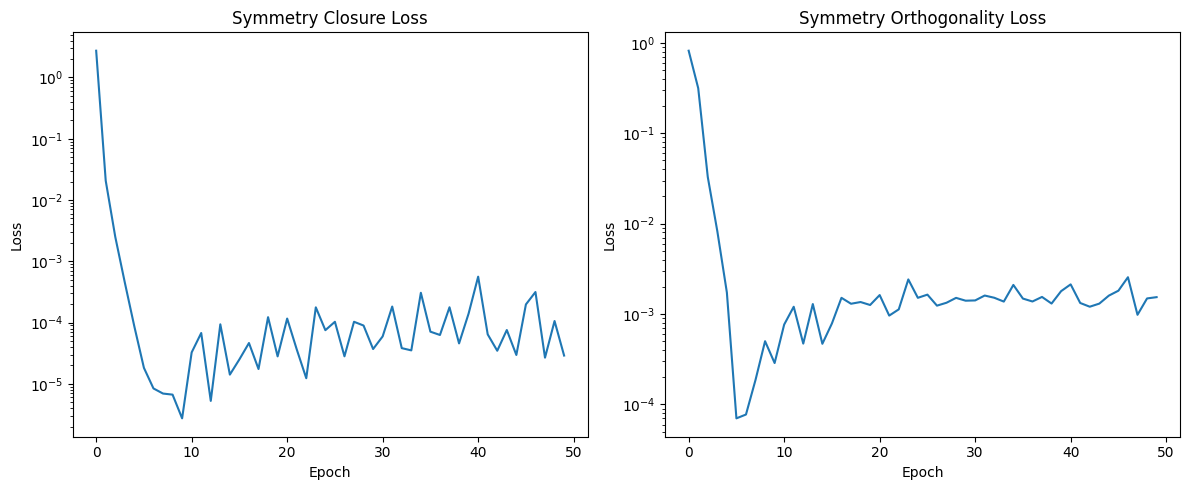


=== Testing Symmetry Preservation ===


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [70]:
model_symmetry = None

def main():
    """
    Complete workflow: RL training → Symmetry detection
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Parameters
    env_name = 'CartPole-v1'
    latent_dim = 4
    num_generators = 6  # SO(4) has 6 generators

    print("Starting complete workflow...")

    # PHASE 1: Train PPO agent (RL training)
    # trained_agent = "/content/trained_ppo_cartpole.pt" # This was the issue, it was a string
    # We need to train the agent first if it's not already saved and loaded




    # PHASE 3: Initialize and train symmetry generators
    model_symmetry = GroupLatent(num_features=latent_dim, num_generators=num_generators)
    model_symmetry.to(device)

    # Define M for psi_4d
    M = torch.eye(latent_dim, device=device)
   # M = get_metric(latent_dim, device=device)

    # Train symmetry generators on fixed latent data
    closure_losses, orth_losses = train_symmetry_generators(
        model_symmetry, latent_data, device=device, epochs=50,M=M)
    torch.save(model_symmetry.state_dict(), "model_symmetry_cartpole.pt")

    # PHASE 4: Analysis and visualization
    print("\n" + "="*60)
    print("TRAINING COMPLETE - ANALYZING RESULTS")
    print("="*60)

    # Analyze generators
    analyze_generators(model_symmetry)

    # Plot generators
    plot_generators(model_symmetry)

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(closure_losses)
    plt.title('Symmetry Closure Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.plot(orth_losses)
    plt.title('Symmetry Orthogonality Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Test symmetry preservation
    print("\n=== Testing Symmetry Preservation ===")
    test_batch = latent_data[:100].to(device)
    theta_test = [(2*torch.rand(test_batch.shape[0], device=device) - 1)
                  for _ in range(num_generators)]

    with torch.no_grad():
        transformed_batch = model_symmetry(theta=theta_test, x=test_batch)

        original_invariant = psi_4d(test_batch)
        transformed_invariant = psi_4d(transformed_batch)

        invariant_error = torch.abs(original_invariant - transformed_invariant).mean()

    print(f"Average invariant preservation error: {invariant_error:.6f}")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print("✓ Phase 1: PPO agent trained on CartPole (RL)")
    print("✓ Phase 2: Latent data generated from trained agent")
    print("✓ Phase 3: Symmetry generators trained on fixed latent data")
    print("✓ Phase 4: 6 SO(4) generators learned and visualized")
    print("✓ No augmentation - pure symmetry discovery")


    return  model_symmetry, latent_data


model_symmetry, latent_data = main()

In [43]:
'''%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

import torch
from tensordict import TensorDict
from typing import Optional

from rsl_rl.env import VecEnv



@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    """Augment observations and actions for CartPole using learned symmetry generators.

    Trained on raw CartPole states from generate_improved_cartpole_dataset:
    - No normalization applied
    - Reflection augmentation: position/velocity flipped (indices 0,1)
    - Generators expect raw states as latents
    """

    # observations - ONLY policy group
    if obs is not None:
        batch_size = obs.batch_size[0]
        obs_aug = obs.repeat(2)  # original + symmetric

        if env is None or not hasattr(env, "model_symmetry"):
            # fallback: simple reflection (matching your dataset generation)
            obs_aug["policy"][:batch_size] = obs["policy"]
            obs_aug["policy"][batch_size : 2 * batch_size, [0, 1]] = -obs["policy"][:, [0, 1]]
        else:
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # -- original
            obs_aug["policy"][:batch_size] = obs["policy"]

            # -- generator-based symmetric version (trained on raw states)
            s = obs["policy"].to(dev)  # (B, 4) raw CartPole states

            # NO normalization - your generators saw raw states directly
            z = s  # raw state = latent

            # sample theta per generator per sample (matching train_symmetry_generators)
            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]

            # apply symmetry: z' = model_symmetry(theta=theta, x=z)
            z_prime = model_symmetry(theta=theta, x=z)  # (B, 4)

            obs_aug["policy"][batch_size : 2 * batch_size] = z_prime.to(obs["policy"].device)
    else:
        obs_aug = None

    # actions
    actions_aug = None
    if actions is not None:
        batch_size = actions.shape[0]
        actions_aug = torch.zeros(batch_size * 2, actions.shape[1], device=actions.device)
        # -- original
        actions_aug[:batch_size] = actions
        # -- left-right flip (consistent with position/velocity reflection)
        actions_aug[batch_size : 2 * batch_size] = 1 - actions

    return obs_aug, actions_aug
''''

Overwriting /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


In [68]:
%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

import torch
from tensordict import TensorDict
from typing import Optional

from rsl_rl.env import VecEnv


@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    """Augment observations AND actions for CartPole using learned symmetry generators.

    Both obs and actions are transformed by the SAME symmetry flow:
    - obs["policy"] → model_symmetry(theta, obs["policy"])
    - actions → model_symmetry(theta, actions_expanded)
    """

    # observations - ONLY policy group
    if obs is not None:
        batch_size = obs.batch_size[0]
        obs_aug = obs.repeat(2)  # original + symmetric

        if env is None or not hasattr(env, "model_symmetry"):
            # fallback: simple reflection
            obs_aug["policy"][:batch_size] = obs["policy"]
            obs_aug["policy"][batch_size : 2 * batch_size, [0, 1]] = -obs["policy"][:, [0, 1]]
        else:
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # -- original
            obs_aug["policy"][:batch_size] = obs["policy"]

            # -- generator-based symmetric version
            s = obs["policy"].to(dev)  # (B, 4)
            z = s  # raw state = latent

            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            z_prime = model_symmetry(theta=theta, x=z)  # (B, 4)

            obs_aug["policy"][batch_size : 2 * batch_size] = z_prime.to(obs["policy"].device)
    else:
        obs_aug = None

    # actions - APPLY SAME SYMMETRY TRANSFORMATION
    actions_aug = None
    if actions is not None:
        batch_size = actions.shape[0]
        actions_aug = torch.zeros(batch_size * 2, actions.shape[1], device=actions.device)

        # -- original
        actions_aug[:batch_size] = actions

        if env is not None and hasattr(env, "model_symmetry"):
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # Expand discrete actions to match state dim (4) for symmetry flow
            # One-hot encode: actions (B,1) → actions_expanded (B,4)
            actions_onehot = torch.zeros(batch_size, 4, device=dev)
            actions_onehot.scatter_(1, actions.unsqueeze(1).to(dev), 1.0)  # (B,4)

            # Apply SAME symmetry flow as states
            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            actions_sym = model_symmetry(theta=theta, x=actions_onehot)  # (B,4)

            # Convert back to discrete actions: argmax over transformed distribution
            actions_sym_discrete = torch.argmax(actions_sym, dim=1)  # (B,)

            actions_aug[batch_size : 2 * batch_size] = actions_sym_discrete.to(actions.device)
        else:
            # fallback: simple flip
            actions_aug[batch_size : 2 * batch_size] = 1 - actions

    return obs_aug, actions_aug


Overwriting /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


In [69]:
import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 100    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
model_symmetry = GroupLatent(num_features=4, num_generators=6).to(device)
model_symmetry.load_state_dict(torch.load("model_symmetry_cartpole.pt"))
env.model_symmetry = model_symmetry
runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])


OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                            Learning iteration 0/100                             

                            Total steps: 192 
                       Steps per second: 677 
                        Collection time: 0.080s 
                          Learning time: 0.204s 
                        Mean value loss: 67.0136
                    Mean surrogate loss: 0.2042
                      Mean entropy loss: 2.8449
                          Mean rnd loss: 0.0947
                     Mean symmetry loss: 0.5954
                  Mean extrinsic reward: 18.33
                  Mean intrinsic reward: 0.00
                            Mean reward: 18.33
                    Mean episode length: 18.33
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 0.28s
                           Time elapsed: 00:

In [46]:
import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 100    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
model_symmetry = GroupLatent(num_features=4, num_generators=6).to(device)
model_symmetry.load_state_dict(torch.load("model_symmetry_cartpole.pt"))
env.model_symmetry = model_symmetry
runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])


OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                            Learning iteration 0/100                             

                            Total steps: 192 
                       Steps per second: 648 
                        Collection time: 0.082s 
                          Learning time: 0.214s 
                        Mean value loss: 50.5214
                    Mean surrogate loss: 0.1993
                      Mean entropy loss: 2.8373
                          Mean rnd loss: 1.0046
                     Mean symmetry loss: 0.0904
                  Mean extrinsic reward: 15.86
                  Mean intrinsic reward: 0.00
                            Mean reward: 15.86
                    Mean episode length: 15.86
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 0.30s
                           Time elapsed: 00:

#NOrmalised

In [72]:
import gymnasium as gym
import torch
import numpy as np
from tqdm import tqdm

def generate_improved_cartpole_dataset(num_episodes=5000, max_steps=300, device='cpu'):
    """
    Generate larger, more diverse symmetry-aware CartPole dataset.
    Returns ONLY the final normalized dataset tensor.
    """
    print("Generating Improved Symmetry-Aware CartPole Dataset...")

    # Reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    env = gym.make('CartPole-v1', render_mode=None)
    all_states = []

    for _ in tqdm(range(num_episodes), desc="Episodes"):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        episode_states = []

        for _ in range(max_steps):
            # --- Diverse actions: mix of policy and random ---
            # If angle (index 2) is significant (> 0.1 rad), use policy to stabilize
            if np.abs(state[2]) > 0.1:
                action = 1 if state[2] > 0 else 0
            else:
                # Otherwise random exploration
                action = env.action_space.sample()

            step_result = env.step(action)
            next_state = step_result[0]
            terminated = step_result[2]
            truncated = step_result[3] if len(step_result) > 4 else False

            episode_states.append(state.copy())
            state = next_state

            if terminated or truncated:
                break

        all_states.extend(episode_states)

    env.close()

    # --- Create symmetric dataset (original + reflected) ---
    states = np.array(all_states)
    reflected = states.copy()
    reflected[:, [0, 1]] *= -1  # Reflect position and velocity

    full_dataset = np.concatenate([states, reflected], axis=0)

    # --- Normalization ---
    data = torch.tensor(full_dataset, dtype=torch.float32).to(device)
    mean = data.mean(dim=0)
    std = data.std(dim=0) + 1e-8
    normalized_data = (data - mean) / std

    # Save full details to disk (so you don't lose mean/std for un-normalization later)
    torch.save({
        'raw_data': full_dataset,
        'mean': mean.cpu(),
        'std': std.cpu()
    }, 'improved_cartpole_symmetry.pt')

    print(f"Saved dataset to disk. Total samples: {len(normalized_data)}")

    # Return ONLY the final dataset as requested
    return normalized_data

In [73]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

latent_data = generate_improved_cartpole_dataset(device=device)

Generating Improved Symmetry-Aware CartPole Dataset...


Episodes: 100%|██████████| 5000/5000 [00:04<00:00, 1158.36it/s]


Saved dataset to disk. Total samples: 428834


Using device: cuda
Starting complete workflow...
=== PHASE 2: Training Symmetry Generators ===


Epoch 1/15: 100%|██████████| 419/419 [00:11<00:00, 35.65it/s]


Epoch 1 - Closure: 29.985263, Orthogonality: 0.950211, Skew-Sym: 4.656353, Magnitude: 3.783275


Epoch 2/15: 100%|██████████| 419/419 [00:11<00:00, 35.82it/s]


Epoch 2 - Closure: 2.101325, Orthogonality: 0.909378, Skew-Sym: 1.176985, Magnitude: 3.431738


Epoch 3/15: 100%|██████████| 419/419 [00:11<00:00, 35.69it/s]


Epoch 3 - Closure: 0.795557, Orthogonality: 0.859489, Skew-Sym: 0.567338, Magnitude: 3.495089


Epoch 4/15: 100%|██████████| 419/419 [00:11<00:00, 36.04it/s]


Epoch 4 - Closure: 0.278184, Orthogonality: 0.761560, Skew-Sym: 0.284101, Magnitude: 3.537786


Epoch 5/15: 100%|██████████| 419/419 [00:11<00:00, 35.82it/s]


Epoch 5 - Closure: 0.095881, Orthogonality: 0.602177, Skew-Sym: 0.135910, Magnitude: 3.591057


Epoch 6/15: 100%|██████████| 419/419 [00:11<00:00, 35.71it/s]


Epoch 6 - Closure: 0.028660, Orthogonality: 0.352263, Skew-Sym: 0.056451, Magnitude: 3.690992


Epoch 7/15: 100%|██████████| 419/419 [00:11<00:00, 35.83it/s]


Epoch 7 - Closure: 0.007431, Orthogonality: 0.145901, Skew-Sym: 0.017979, Magnitude: 3.798573


Epoch 8/15: 100%|██████████| 419/419 [00:11<00:00, 35.74it/s]


Epoch 8 - Closure: 0.001442, Orthogonality: 0.067042, Skew-Sym: 0.004251, Magnitude: 3.780911


Epoch 9/15: 100%|██████████| 419/419 [00:11<00:00, 35.96it/s]


Epoch 9 - Closure: 0.000348, Orthogonality: 0.035539, Skew-Sym: 0.000970, Magnitude: 3.624142


Epoch 10/15: 100%|██████████| 419/419 [00:11<00:00, 35.66it/s]


Epoch 10 - Closure: 0.000135, Orthogonality: 0.019485, Skew-Sym: 0.000313, Magnitude: 3.350366


Epoch 11/15: 100%|██████████| 419/419 [00:11<00:00, 35.78it/s]


Epoch 11 - Closure: 0.000073, Orthogonality: 0.009831, Skew-Sym: 0.000163, Magnitude: 2.982837


Epoch 12/15: 100%|██████████| 419/419 [00:11<00:00, 36.02it/s]


Epoch 12 - Closure: 0.000042, Orthogonality: 0.004218, Skew-Sym: 0.000101, Magnitude: 2.553541


Epoch 13/15: 100%|██████████| 419/419 [00:11<00:00, 35.80it/s]


Epoch 13 - Closure: 0.000023, Orthogonality: 0.001417, Skew-Sym: 0.000062, Magnitude: 2.100639


Epoch 14/15: 100%|██████████| 419/419 [00:11<00:00, 35.69it/s]


Epoch 14 - Closure: 0.000012, Orthogonality: 0.000324, Skew-Sym: 0.000032, Magnitude: 1.661656


Epoch 15/15: 100%|██████████| 419/419 [00:11<00:00, 35.30it/s]


Epoch 15 - Closure: 0.000007, Orthogonality: 0.000037, Skew-Sym: 0.000016, Magnitude: 1.266204

=== EXAMPLE USAGE AFTER TRAINING ===
Original z (eval batch):
tensor([[-0.2216, -0.0264,  0.4105,  0.0071],
        [-0.2237, -0.2708,  0.4124,  0.3270],
        [-0.2461, -0.0278,  0.4762,  0.0339],
        [-0.2484,  0.2150,  0.4832, -0.2569]], device='cuda:0')

Per-sample product Π exp(θ_i G_i) with Taylor approximation (B, D, D):
tensor([[[ 0.9287, -0.2536, -0.1327, -0.2351],
         [ 0.2886,  0.9464,  0.1375,  0.0382],
         [ 0.0681, -0.1586,  0.9786, -0.1123],
         [ 0.2231, -0.1178,  0.0762,  0.9647]],

        [[ 0.9520, -0.1124, -0.1569, -0.2367],
         [ 0.0820,  0.9875, -0.1156, -0.0645],
         [ 0.2107,  0.1054,  0.9590,  0.1589],
         [ 0.2064,  0.0211, -0.2069,  0.9566]],

        [[ 0.9099,  0.2824, -0.2592, -0.1579],
         [-0.2413,  0.9543,  0.1071,  0.1449],
         [ 0.2569, -0.0227,  0.9568, -0.1339],
         [ 0.2205, -0.1000,  0.0746,  0.9669]],

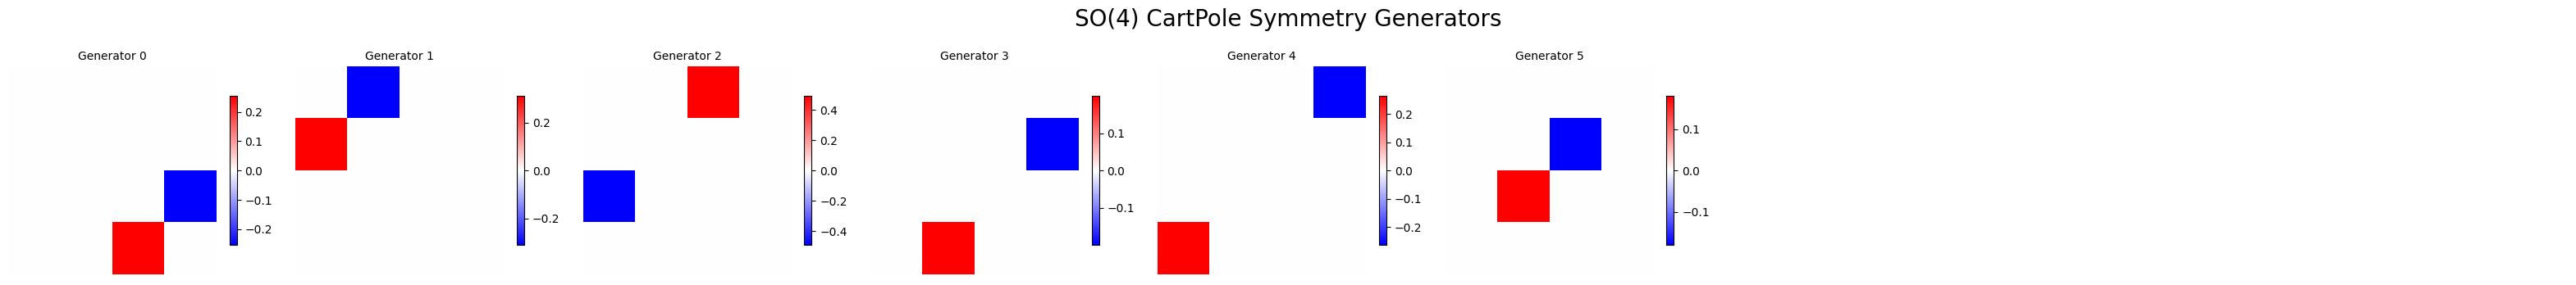

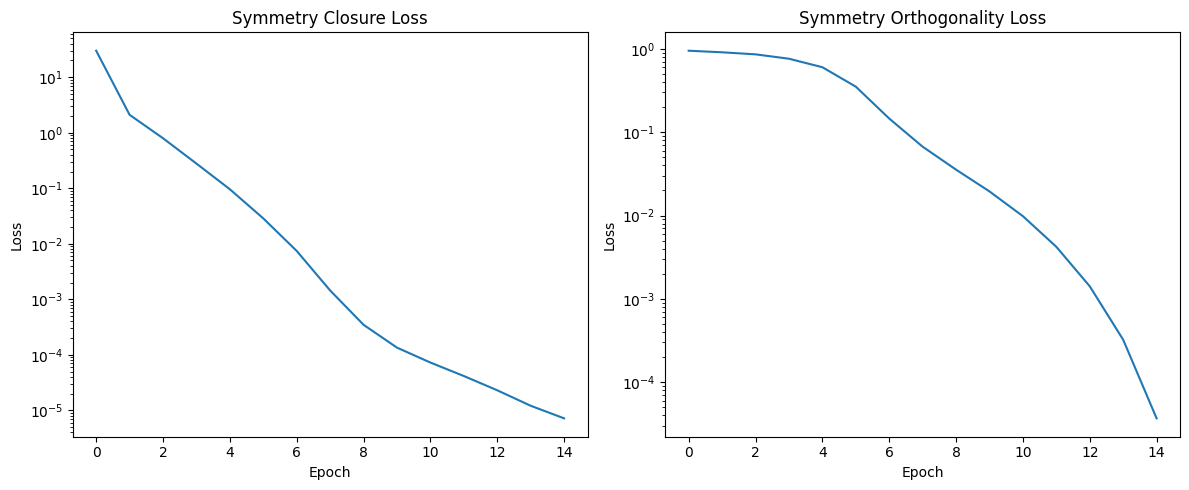


=== Testing Symmetry Preservation ===
Average invariant preservation error: 0.001673

SUMMARY
✓ Phase 1: PPO agent trained on CartPole (RL)
✓ Phase 2: Latent data generated from trained agent
✓ Phase 3: Symmetry generators trained on fixed latent data
✓ Phase 4: 6 SO(4) generators learned and visualized
✓ No augmentation - pure symmetry discovery


In [74]:
model_symmetry = None

def main():
    """
    Complete workflow: RL training → Symmetry detection
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Parameters
    env_name = 'CartPole-v1'
    latent_dim = 4
    num_generators = 6  # SO(4) has 6 generators

    print("Starting complete workflow...")

    # PHASE 1: Train PPO agent (RL training)
    # trained_agent = "/content/trained_ppo_cartpole.pt" # This was the issue, it was a string
    # We need to train the agent first if it's not already saved and loaded




    # PHASE 3: Initialize and train symmetry generators
    model_symmetry = GroupLatent(num_features=latent_dim, num_generators=num_generators)
    model_symmetry.to(device)

    # Define M for psi_4d
    M = torch.eye(latent_dim, device=device)
   # M = get_metric(latent_dim, device=device)

    # Train symmetry generators on fixed latent data
    closure_losses, orth_losses = train_symmetry_generators(
        model_symmetry, latent_data, device=device, epochs=15,M=M)
    torch.save(model_symmetry.state_dict(), "model_symmetry_cartpole.pt")

    # PHASE 4: Analysis and visualization
    print("\n" + "="*60)
    print("TRAINING COMPLETE - ANALYZING RESULTS")
    print("="*60)

    # Analyze generators
    analyze_generators(model_symmetry)

    # Plot generators
    plot_generators(model_symmetry)

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(closure_losses)
    plt.title('Symmetry Closure Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.plot(orth_losses)
    plt.title('Symmetry Orthogonality Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Test symmetry preservation
    print("\n=== Testing Symmetry Preservation ===")
    test_batch = latent_data[:100].to(device)
    theta_test = [(2*torch.rand(test_batch.shape[0], device=device) - 1)
                  for _ in range(num_generators)]

    with torch.no_grad():
        transformed_batch = model_symmetry(theta=theta_test, x=test_batch)

        original_invariant = psi_4d(test_batch)
        transformed_invariant = psi_4d(transformed_batch)

        invariant_error = torch.abs(original_invariant - transformed_invariant).mean()

    print(f"Average invariant preservation error: {invariant_error:.6f}")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print("✓ Phase 1: PPO agent trained on CartPole (RL)")
    print("✓ Phase 2: Latent data generated from trained agent")
    print("✓ Phase 3: Symmetry generators trained on fixed latent data")
    print("✓ Phase 4: 6 SO(4) generators learned and visualized")
    print("✓ No augmentation - pure symmetry discovery")


    return  model_symmetry, latent_data


model_symmetry, latent_data = main()

In [60]:
%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

import torch
from tensordict import TensorDict
from typing import Optional

from rsl_rl.env import VecEnv


@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    """Augment observations AND actions for CartPole using learned symmetry generators.

    Handles normalization from previous symmetry training:
    - env.symm_mean, env.symm_std: normalization stats from symmetry dataset
    - model_symmetry trained on normalized states
    """

    # observations - ONLY policy group
    if obs is not None:
        batch_size = obs.batch_size[0]
        obs_aug = obs.repeat(2)  # original + symmetric

        if env is None or not hasattr(env, "model_symmetry"):
            # fallback: simple reflection
            obs_aug["policy"][:batch_size] = obs["policy"]
            obs_aug["policy"][batch_size : 2 * batch_size, [0, 1]] = -obs["policy"][:, [0, 1]]
        else:
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # -- original
            obs_aug["policy"][:batch_size] = obs["policy"]

            # -- generator-based symmetric version
            s = obs["policy"].to(dev)  # (B, 4) raw RL states

            # Normalize to match symmetry training data
            if hasattr(env, "symm_mean") and hasattr(env, "symm_std"):
                mean = env.symm_mean.to(dev)
                std = env.symm_std.to(dev)
                z = (s - mean) / (std + 1e-8)  # normalize
            else:
                z = s  # no normalization available

            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            z_prime_norm = model_symmetry(theta=theta, x=z)  # (B, 4) normalized symmetric

            # De-normalize back to raw state space
            if hasattr(env, "symm_mean") and hasattr(env, "symm_std"):
                z_prime = z_prime_norm * std + mean
            else:
                z_prime = z_prime_norm

            obs_aug["policy"][batch_size : 2 * batch_size] = z_prime.to(obs["policy"].device)
    else:
        obs_aug = None

    # actions - APPLY SAME SYMMETRY TRANSFORMATION
    actions_aug = None
    if actions is not None:
        batch_size = actions.shape[0]
        actions_aug = torch.zeros(batch_size * 2, actions.shape[1], device=actions.device)

        # -- original
        actions_aug[:batch_size] = actions

        if env is not None and hasattr(env, "model_symmetry"):
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # One-hot encode discrete actions: (B,1) → (B,4)
            actions_onehot_raw = torch.zeros(batch_size, 4, device=dev)
            actions_onehot_raw.scatter_(1, actions.unsqueeze(1).to(dev), 1.0)

            # Normalize actions if stats available (treat as 4D vector)
            if hasattr(env, "symm_mean") and hasattr(env, "symm_std"):
                mean = env.symm_mean.to(dev)
                std = env.symm_std.to(dev)
                actions_onehot_norm = (actions_onehot_raw - mean) / (std + 1e-8)
            else:
                actions_onehot_norm = actions_onehot_raw

            # Apply SAME symmetry flow
            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            actions_sym_norm = model_symmetry(theta=theta, x=actions_onehot_norm)

            # De-normalize back
            if hasattr(env, "symm_mean") and hasattr(env, "symm_std"):
                actions_sym_raw = actions_sym_norm * std + mean
            else:
                actions_sym_raw = actions_sym_norm

            # Convert back to discrete: argmax
            actions_sym_discrete = torch.argmax(actions_sym_raw, dim=1)

            actions_aug[batch_size : 2 * batch_size] = actions_sym_discrete.to(actions.device)
        else:
            # fallback: simple flip
            actions_aug[batch_size : 2 * batch_size] = 1 - actions

    return obs_aug, actions_aug


Overwriting /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


In [63]:
import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 100    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
# Load normalization stats from your symmetry training dataset
symm_stats = torch.load("improved_cartpole_symmetry.pt", map_location=device, weights_only=False)
env.symm_mean = symm_stats["mean"].to(device)   # (4,)
env.symm_std = symm_stats["std"].to(device)     # (4,)

# Load trained generators
model_symmetry = GroupLatent(num_features=4, num_generators=6).to(device)
model_symmetry.load_state_dict(torch.load("model_symmetry_cartpole.pt", map_location=device, weights_only=False))
env.model_symmetry = model_symmetry

runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir, device=device)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])

OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                            Learning iteration 0/100                             

                            Total steps: 192 
                       Steps per second: 776 
                        Collection time: 0.087s 
                          Learning time: 0.161s 
                        Mean value loss: 61.2401
                    Mean surrogate loss: 0.0768
                      Mean entropy loss: 2.8413
                          Mean rnd loss: 0.2405
                     Mean symmetry loss: 0.1362
                  Mean extrinsic reward: 17.75
                  Mean intrinsic reward: 0.00
                            Mean reward: 17.75
                    Mean episode length: 17.75
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 0.25s
                           Time elapsed: 00:

#normalised env

In [75]:
import gymnasium as gym
import torch
from gymnasium import spaces
from tensordict import TensorDict
from rsl_rl.env import VecEnv

class CartPoleVecEnv(VecEnv):
    def __init__(self, num_envs: int = 8, device: str = "cpu", max_episode_length: int = 500):
        self.num_envs = num_envs
        self.device = torch.device(device)
        self.max_episode_length = max_episode_length
        self.episode_length_buf = torch.zeros(num_envs, dtype=torch.long, device=self.device)

        # underlying envs
        self.envs = [gym.make("CartPole-v1") for _ in range(num_envs)]
        base_env = self.envs[0]

        # expose gym-like spaces so rsl_rl infers dims cleanly
        self.observation_space = base_env.observation_space  # Box(4,)
        self.action_space = base_env.action_space            # Discrete(2)

        self.num_actions = int(self.action_space.n)

        obs0, _ = base_env.reset()
        obs_dim = obs0.shape[0]
        self.obs_buf = torch.zeros(num_envs, obs_dim, device=self.device, dtype=torch.float32)

        self.cfg = {"env_name": "CartPole-v1"}

        class _DummyUnwrapped:
            def __init__(self, step_dt: float):
                self.step_dt = step_dt

        # CartPole dt
        self.unwrapped = _DummyUnwrapped(step_dt=0.02)

        # Symmetry model placeholders (set externally)
        self.model_symmetry = None
        self.symm_mean = None
        self.symm_std = None

        self._reset_all()

    def attach_symmetry_model(self, model_symmetry_path: str, stats_path: str = None):
        """Attach trained symmetry model and normalization stats."""
        # Load symmetry model
        from cartpole_symmetry_model import GroupLatent  # adjust import path
        self.model_symmetry = GroupLatent(num_features=4, num_generators=6).to(self.device)
        self.model_symmetry.load_state_dict(torch.load(model_symmetry_path, map_location=self.device))

        # Load normalization stats (optional)
        if stats_path:
            stats = torch.load(stats_path, map_location=self.device)
            self.symm_mean = stats["mean"].to(self.device)
            self.symm_std = stats["std"].to(self.device)
            print(f"Loaded symmetry stats: mean={self.symm_mean.tolist()}, std={self.symm_std.tolist()}")

        print("Symmetry model attached successfully!")

    def _reset_all(self):
        for i, env in enumerate(self.envs):
            o, _ = env.reset()
            self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
        self.episode_length_buf.zero_()

    def get_observations(self) -> TensorDict:
        return TensorDict(
            {
                "policy": self.obs_buf.clone(),
                "privileged": self.obs_buf.clone(),
            },
            batch_size=[self.num_envs],
            device=self.device,
        )

    def step(self, actions: torch.Tensor):
        # Handle different action shapes from the policy:
        # (num_envs, num_actions) → choose greedy action
        if actions.dim() == 2 and actions.shape[1] > 1:
            actions = torch.argmax(actions, dim=-1)

        # (num_envs, 1) → squeeze to (num_envs,)
        if actions.dim() == 2:
            actions = actions.squeeze(-1)

        rewards = torch.zeros(self.num_envs, device=self.device)
        dones = torch.zeros(self.num_envs, dtype=torch.bool, device=self.device)
        time_outs = torch.zeros(self.num_envs, dtype=torch.bool, device=self.device)

        for i, env in enumerate(self.envs):
            a = int(actions[i].item())
            o, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
            rewards[i] = r
            dones[i] = done

            self.episode_length_buf[i] += 1
            if self.episode_length_buf[i] >= self.max_episode_length:
                time_outs[i] = True
                done = True

            if done:
                o, _ = env.reset()
                self.obs_buf[i] = torch.as_tensor(o, device=self.device, dtype=torch.float32)
                self.episode_length_buf[i] = 0

        obs_td = self.get_observations()
        extras = {
            "time_outs": time_outs,
            "log": {},
        }
        return obs_td, rewards, dones, extras


In [76]:
%%writefile /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py
# Copyright (c) 2021-2025, ETH Zurich and NVIDIA CORPORATION
# All rights reserved.
#
# SPDX-License-Identifier: BSD-3-Clause

from __future__ import annotations

import torch
from tensordict import TensorDict
from typing import Optional

from rsl_rl.env import VecEnv


@torch.no_grad()
def cartpole_symmetry(obs=None, actions=None, env=None, obs_type: str = "policy"):
    """Augment observations AND actions for CartPole using learned symmetry generators.

    Both obs and actions are transformed by the SAME symmetry flow:
    - obs["policy"] → model_symmetry(theta, obs["policy"])
    - actions → model_symmetry(theta, actions_expanded)
    """

    # observations - ONLY policy group
    if obs is not None:
        batch_size = obs.batch_size[0]
        obs_aug = obs.repeat(2)  # original + symmetric

        if env is None or not hasattr(env, "model_symmetry"):
            # fallback: simple reflection
            obs_aug["policy"][:batch_size] = obs["policy"]
            obs_aug["policy"][batch_size : 2 * batch_size, [0, 1]] = -obs["policy"][:, [0, 1]]
        else:
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # -- original
            obs_aug["policy"][:batch_size] = obs["policy"]

            # -- generator-based symmetric version
            s = obs["policy"].to(dev)  # (B, 4)
            z = s  # raw state = latent

            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            z_prime = model_symmetry(theta=theta, x=z)  # (B, 4)

            obs_aug["policy"][batch_size : 2 * batch_size] = z_prime.to(obs["policy"].device)
    else:
        obs_aug = None

    # actions - APPLY SAME SYMMETRY TRANSFORMATION
    actions_aug = None
    if actions is not None:
        batch_size = actions.shape[0]
        actions_aug = torch.zeros(batch_size * 2, actions.shape[1], device=actions.device)

        # -- original
        actions_aug[:batch_size] = actions

        if env is not None and hasattr(env, "model_symmetry"):
            model_symmetry = env.model_symmetry
            dev = next(model_symmetry.parameters()).device

            # Expand discrete actions to match state dim (4) for symmetry flow
            # One-hot encode: actions (B,1) → actions_expanded (B,4)
            actions_onehot = torch.zeros(batch_size, 4, device=dev)
            actions_onehot.scatter_(1, actions.unsqueeze(1).to(dev), 1.0)  # (B,4)

            # Apply SAME symmetry flow as states
            num_generators = getattr(model_symmetry, "num_generators", None)
            if num_generators is None:
                num_generators = getattr(model_symmetry, "numgenerators")

            theta = [(2 * torch.rand(batch_size, device=dev) - 1) for _ in range(num_generators)]
            actions_sym = model_symmetry(theta=theta, x=actions_onehot)  # (B,4)

            # Convert back to discrete actions: argmax over transformed distribution
            actions_sym_discrete = torch.argmax(actions_sym, dim=1)  # (B,)

            actions_aug[batch_size : 2 * batch_size] = actions_sym_discrete.to(actions.device)
        else:
            # fallback: simple flip
            actions_aug[batch_size : 2 * batch_size] = 1 - actions

    return obs_aug, actions_aug


Overwriting /content/rsl_rl/rsl_rl/modules/cartpole_symmetry_utils.py


#Final output skew generator used


In [77]:
import yaml
from types import SimpleNamespace
from rsl_rl.runners import OnPolicyRunner
#import cartpole_symmetry

yaml_config_string = """
runner:
  class_name: OnPolicyRunner
  # General
  num_steps_per_env: 24  # Number of steps per environment per iteration
  max_iterations: 100    # Number of policy updates
  seed: 1
  # Observations
  obs_groups: {"policy": ["policy"], "critic": ["policy", "privileged"]}  # Maps observation groups to sets. See `vec_env.py` for more information
  # Logging parameters
  save_interval: 50  # Check for potential saves every `save_interval` iterations
  experiment_name: walking_experiment
  run_name: ""
  # Logging writer
  logger: tensorboard  # tensorboard, neptune, wandb
  neptune_project: legged_gym
  wandb_project: legged_gym

  # Policy
  policy:
    class_name: ActorCritic
    activation: elu
    actor_obs_normalization: false
    critic_obs_normalization: false
    actor_hidden_dims: [256, 256, 256]
    critic_hidden_dims: [256, 256, 256]
    init_noise_std: 1.0
    noise_std_type: "scalar"  # 'scalar' or 'log'
    state_dependent_std: false

  # Algorithm
  algorithm:
    class_name: PPO
    # Training
    learning_rate: 0.001
    num_learning_epochs: 5
    num_mini_batches: 4  # mini batch size = num_envs * num_steps / num_mini_batches
    schedule: adaptive  # adaptive, fixed
    # Value function
    value_loss_coef: 1.0
    clip_param: 0.2
    use_clipped_value_loss: true
    # Surrogate loss
    desired_kl: 0.01
    entropy_coef: 0.01
    gamma: 0.99
    lam: 0.95
    max_grad_norm: 1.0
    # Miscellaneous
    normalize_advantage_per_mini_batch: false

    # Random network distillation
    rnd_cfg:
      weight: 0.0  # Initial weight of the RND reward
      weight_schedule: null  # This is a dictionary with a required key called "mode". Please check the RND module for more information
      reward_normalization: false  # Whether to normalize RND reward
      # Learning parameters
      learning_rate: 0.001  # Learning rate for RND
      # Network parameters
      num_outputs: 1  # Number of outputs of RND network. Note: if -1, then the network will use dimensions of the observation
      predictor_hidden_dims: [-1]  # Hidden dimensions of predictor network
      target_hidden_dims: [-1]  # Hidden dimensions of target network

    # Symmetry augmentation
    symmetry_cfg:
      use_data_augmentation: true  # This adds symmetric trajectories to the batch
      use_mirror_loss: false  # This adds symmetry loss term to the loss function
      data_augmentation_func: "rsl_rl.modules.cartpole_symmetry_utils:cartpole_symmetry"  # String containing the module and function name to import
      # Example: "legged_gym.envs.locomotion.anymal_c.symmetry:get_symmetric_states"
      mirror_loss_coeff: 0.0  # Coefficient for symmetry loss term. If 0, no symmetry loss is used
"""


def get_train_cfg():
    raw = yaml.safe_load(yaml_config_string)
    # Optional: turn top-level dict into an object-like cfg
    return SimpleNamespace(**raw)
import os

log_dir = "./logs_cartpole"
os.makedirs(log_dir, exist_ok=True)



# Usage:
train_cfg = get_train_cfg()
print(train_cfg.runner["class_name"])   # 'OnPolicyRunner'
# later:
env = CartPoleVecEnv(num_envs=8, device="cuda:0")
model_symmetry = GroupLatent(num_features=4, num_generators=6).to(device)
model_symmetry.load_state_dict(torch.load("model_symmetry_cartpole.pt"))
env.model_symmetry = model_symmetry
runner = OnPolicyRunner(env, train_cfg.runner, log_dir=log_dir)
runner.learn(num_learning_iterations=train_cfg.runner["max_iterations"])


OnPolicyRunner
--------------------------------------------------------------------------------
Resolved observation sets: 
	 policy :  ['policy']
	 critic :  ['policy', 'privileged']
	 rnd_state :  ['policy']
--------------------------------------------------------------------------------
Actor MLP: MLP(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=2, bias=True)
)
Critic MLP: MLP(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


/content/rsl_rl/rsl_rl/utils/utils.py:273: UserWarning: The observation configuration dictionary 'obs_groups' must contain the 'rnd_state' key. As the configuration for 'rnd_state' is missing, the observations from the 'policy' set are used. Consider adding the 'rnd_state' key to the 'obs_groups' dictionary for clarity. This behavior will be removed in a future version.
  warnings.warn(


################################################################################
                            Learning iteration 0/100                             

                            Total steps: 192 
                       Steps per second: 500 
                        Collection time: 0.077s 
                          Learning time: 0.306s 
                        Mean value loss: 56.3389
                    Mean surrogate loss: 0.1559
                      Mean entropy loss: 2.8400
                          Mean rnd loss: 0.3823
                     Mean symmetry loss: 0.1065
                  Mean extrinsic reward: 16.60
                  Mean intrinsic reward: 0.00
                            Mean reward: 16.60
                    Mean episode length: 16.60
                  Mean action noise std: 1.00
--------------------------------------------------------------------------------
                         Iteration time: 0.38s
                           Time elapsed: 00: